# Waves Finality Model

This model evaluates the finality process in the Waves blockchain. By simulating the real block generation mechanics, we calculate how many blocks are required to achieve finality under modeled network conditions.

## Blocks Data

The block data is generated using the utility [`waves-delays-generator`](https://github.com/alexeykiselev/waves-delays-generator). This utility takes as input a list of generator accounts with real balances captured from MainNet in March 2025.

For each generator, a random key pair is generated and associated with its balance.  
At each simulation step, a hit source (VRF) is generated for each generator, and the delay from the previous block is calculated and recorded in the output file.

The block with the smallest delay is selected and stored as the next blockchain block, while other blocks are considered as possible candidates. In subsequent steps, the selected block is used as the reference for generating the next blocks.

In the output file, block delays are recorded for each height (step) and for each generator.

In [153]:
# Imports and model parameters

import math
import hashlib
import base58

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import pyarrow.parquet as pq

# Set charts style
plt.style.use('computermodernstyle.mplstyle')

# Read generators table
generators = pq.read_table("mainnet.generators.parquet").to_pandas()
generators = generators.rename(columns={"id": "generator"})

# Calculate total generation balance
total_balance = generators["balance"].sum()

# Read blocks data
blocks = pq.read_table("mainnet.blocks.parquet").to_pandas()

# Select minimun delays for each height
min_delays = blocks.groupby("height")["delay"].min().reset_index()

# Calculate blocks stats
mean_delay = np.mean(min_delays["delay"])


## Blocks Data Validation

As a first step, we validate the generated block data by calculating the average block delay, which should be close to 60 seconds.

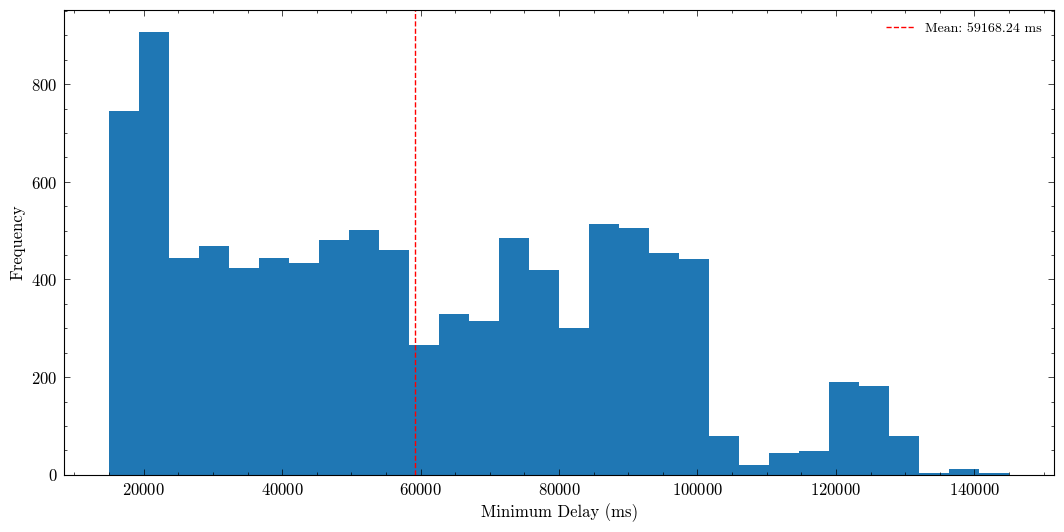

In [154]:
f, ax = plt.subplots(figsize=(12, 6))

ax.set_xlabel(r'Minimum Delay (ms)')
ax.set_ylabel(r'Frequency')
ax.hist(min_delays["delay"], bins=30)
ax.axvline(mean_delay, color="red", linestyle="--", label=f"Mean: {mean_delay:.2f} ms")
ax.legend()
plt.savefig('delays.png', dpi=300)

## Finality Model

Before evaluating finality, we first determine how many alternative blocks were generated close enough to the block with the minimum delay at each height. 

A threshold of 300 milliseconds is used to filter eligible alternative blocks.  
This threshold reflects the fact that blocks and their alternatives could be received by other generators in a different order, making them valid candidates for inclusion in the blockchain and for receiving votes.

Number of blocks where at least one delay (besides min delay) is within 300ms: 144
Maximum number of delays within 300ms for a single block: 18


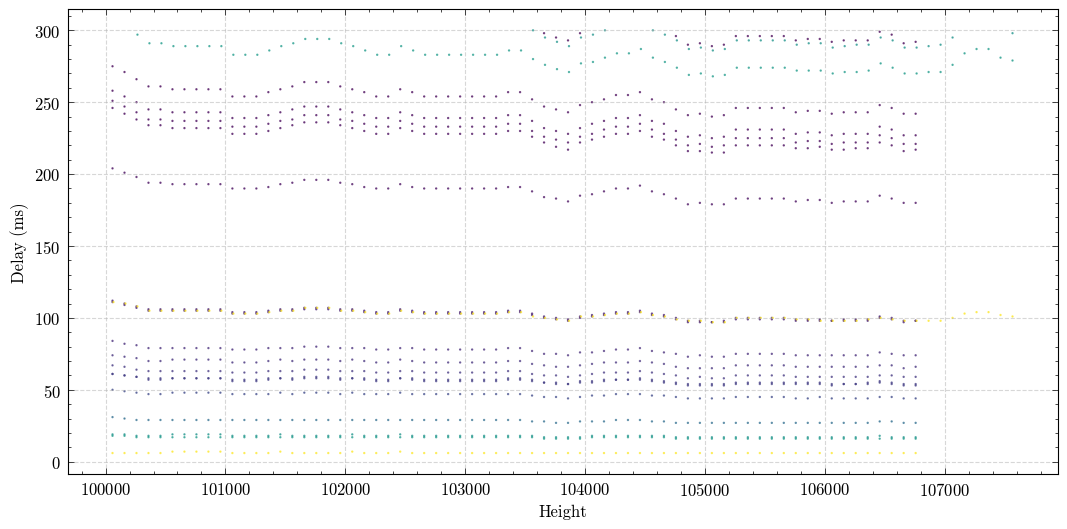

In [155]:
# Block delay difference threshold (in ms)
DELAY_THRESHOLD = 300

# Rename minimun delay column before merging 
min_delays = min_delays.rename(columns={"delay": "min_delay"})

# Merge original blocks data with min delays
merged = blocks.merge(min_delays, on="height")

# Merge generators
merged = merged.merge(generators, on="generator")

# Calculate delay diffs 
merged["delay_diff"] = merged["delay"] - merged["min_delay"]

# Filter delays within DELAY_THRESHOLD of min delay but not equal to min delay
filtered_delays = merged[(merged["delay_diff"] > 0) & (merged["delay_diff"] <= DELAY_THRESHOLD)]

# Count unique block heights where such delays exist
num_blocks_with_extra_delays = filtered_delays["height"].nunique()

# Find the maximum count of alternative blocks within threshold
max_delays_in_block = filtered_delays.groupby("height").size().max()

# Print some stats about found cases of delays within threshold
print(f"Number of blocks where at least one delay (besides min delay) is within {DELAY_THRESHOLD}ms: {num_blocks_with_extra_delays}")
print(f"Maximum number of delays within {DELAY_THRESHOLD}ms for a single block: {max_delays_in_block}")

# Plot2: Other delays
f, ax = plt.subplots(figsize=(12, 6))
ax.scatter(filtered_delays["height"], filtered_delays["delay_diff"],  c=filtered_delays["balance"],  alpha=0.7, s=.5)
ax.set_xlabel(r'Height')
ax.set_ylabel(r'Delay (ms)')
ax.grid(True, linestyle="--", alpha=0.5)
plt.savefig('other_delays.png', dpi=300)


## Finality Model Simulation

This part implements the core logic of the finality model, calculating how many blocks are required to finalize each block under the defined voting rules.

A block is considered final if it receives at least **2/3** of the total generation balances as votes.

Generators are divided into three groups:
- **Block generators**: Generators that produce the block with the minimum delay.
- **Alternative generators**: Generators that produce alternative blocks within the delay threshold.
- **Non-participating generators**: Generators whose delays exceed the threshold and are considered non-participating in block generation at this height.

Each alternative generator receives a `delay_weight` proportional to its closeness to the minimum delay (closer = higher weight).

Non-participating generators are sorted by balance.
Their balances are split as follows:
- The **top 50%** (by balance) are assigned directly to the min delay block.
- The **bottom 50%** are redistributed among alternative blocks proportionally to their `delay_weight`.

For each alternative block, the total vote is calculated as the sum of the generator's own balance and the share of redistributed non-participating balances.

Finally, for each block, we calculate how many additional blocks are needed until finality is achieved. A block may only finalize later if subsequent blocks finalize and "confirm" it.

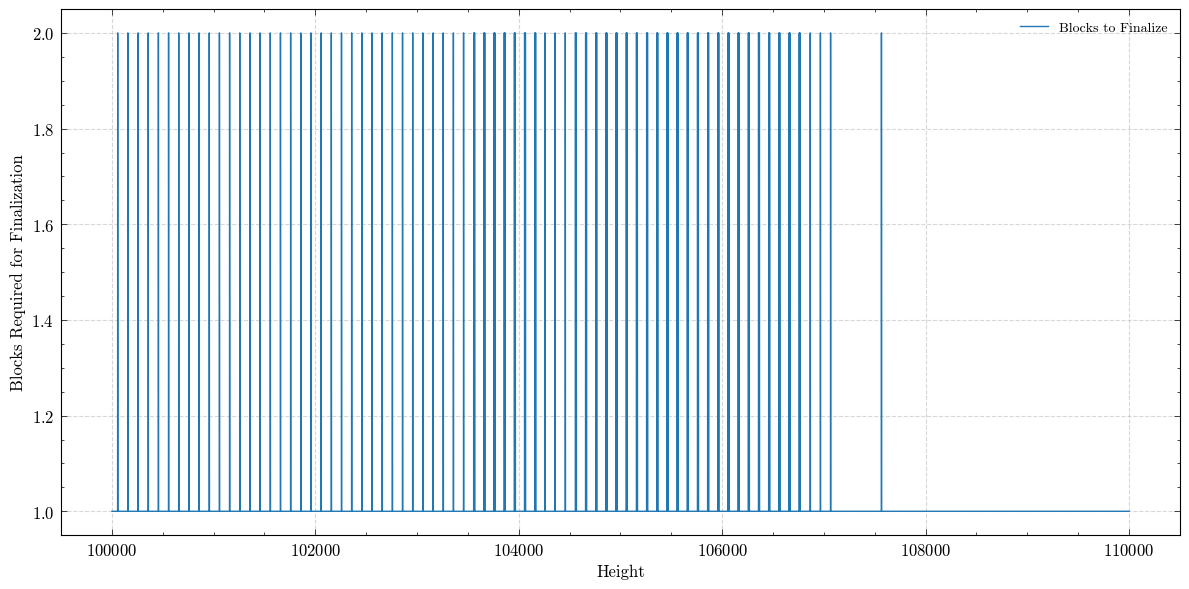

In [156]:
# Fraction of balances supporting block with min delay to achive finality
FINALITY_FRACTION = 2 / 3

# Generators contributing to alternative blocks (delay_diff > 0 and <= threshold)
alternatives = filtered_delays.copy()

# Generators contributing to min delay block (delay_diff == 0)
min_delay_generators = merged[merged["delay_diff"] == 0].copy()

# Generators NOT participating (delay_diff > threshold)
non_participating_generators = merged[merged["delay_diff"] > DELAY_THRESHOLD].copy()

# Compute delay_weight for alternative block generators
alternatives["delay_weight"] = (DELAY_THRESHOLD - alternatives["delay_diff"]) / DELAY_THRESHOLD

# Distribute non-alternative generators balances
def redistribute_non_alt_votes(group):
    # Find non-alternative generators for this block
    height = group.name
    non_gens = non_participating_generators[non_participating_generators["height"] == height].copy()
    if non_gens.empty:
        group["non_alt_vote"] = 0
        return group

    # Sort by balance
    non_gens = non_gens.sort_values("balance")

    # Split into two halves
    split_index = len(non_gens) // 2
    bottom_balances = non_gens.iloc[split_index:]["balance"].values

    # Total available balances to distribute to alternative blocks
    sum_bottom = bottom_balances.sum()
    
    # Assign redistributed votes to alternatives proportionally
    if len(group) > 0:
        group = group.copy()
        group["delay_weight_norm"] = group["delay_weight"] / group["delay_weight"].sum()
        group["non_alt_vote"] = group["delay_weight_norm"] * sum_bottom
    else:
        group["non_alt_vote"] = 0
    
    return group

# Apply redistribution block-by-block
alternatives = alternatives.groupby("height", group_keys=False)[["height", "delay_diff", "balance", "delay_weight"]].apply(redistribute_non_alt_votes)

# Compute total votes

# Alternatives total votes = own balance + redistributed non-alt votes
alternatives["vote"] = alternatives["balance"] + alternatives["non_alt_vote"]

# Min delay block votes
min_votes = min_delay_generators.groupby("height")["balance"].sum().rename("min_votes")

# Sum of top 50% non-alternative balances per block
top_votes = non_participating_generators.groupby("height")[["height", "delay_diff", "balance"]].apply(
    lambda g: g.sort_values("balance", ascending=True).iloc[len(g) // 2:]["balance"].sum()
).rename("top_votes")

# Total min delay block votes = own + top balances
min_votes = min_votes.add(top_votes, fill_value=0)

# Total balances
total_votes = merged.groupby("height")["balance"].sum()

# Compute finality
# Sum alternative votes per block
alt_votes = alternatives.groupby("height")["vote"].sum()

# Compute min delay vote share
min_vote_share = (min_votes / total_votes).fillna(0)

# Decide if block is final
is_final = min_vote_share >= FINALITY_FRACTION

# Compute blocks needed for finalization
depths = []
pending = 0
for final in reversed(is_final.tolist()):
    if final:
        pending = 0
    else:
        pending += 1
    depths.append(pending + 1)

# Store results
finality_df = pd.DataFrame({
    "min_vote_share": min_vote_share,
    "is_final": is_final,
    "blocks_to_finalize": list(reversed(depths))
})

# Plot 3: Finalization over time
f, ax = plt.subplots(figsize=(12, 6))
ax.plot(finality_df.index, finality_df["blocks_to_finalize"], label="Blocks to Finalize")
ax.set_xlabel("Height")
ax.set_ylabel("Blocks Required for Finalization")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig('finalization.png', dpi=300)
plt.show()